## Housing Sale Price Prediction using Ridge and Lasso Regression

### Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

The company wants to know:

- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.

### Business Goal 

 
- Model the price of houses with the available independent variables. 
- This model will then be used by the management to understand how exactly the prices vary with the variables. 
- They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. 
- The model will be a good way for management to understand the pricing dynamics of a new market.

### Approach

- We can determine the optimal value of Lambda for ridge and Lasso regression to build the model that can predict the actual value of the prospective properties.

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE


In [139]:
# reading the dataset
housing = pd.read_csv("train.csv")

In [140]:
# summary of the dataset: 1460 rows, 81 columns, no null values
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [141]:
# head
housing.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [142]:
# Checking the percentage of Null values in all the columns
print('Percentage of Missing Values in each column is as follows:')
print(round(housing.isnull().sum()/len(housing.index)*100,2).sort_values(ascending=False)[ round(housing.isnull().sum()/len(housing.index),2) > 0 ] )

Percentage of Missing Values in each column is as follows:
PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
MasVnrType      59.73
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtQual         2.53
BsmtCond         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
dtype: float64


6 features have more than 40% of missing values

## EDA

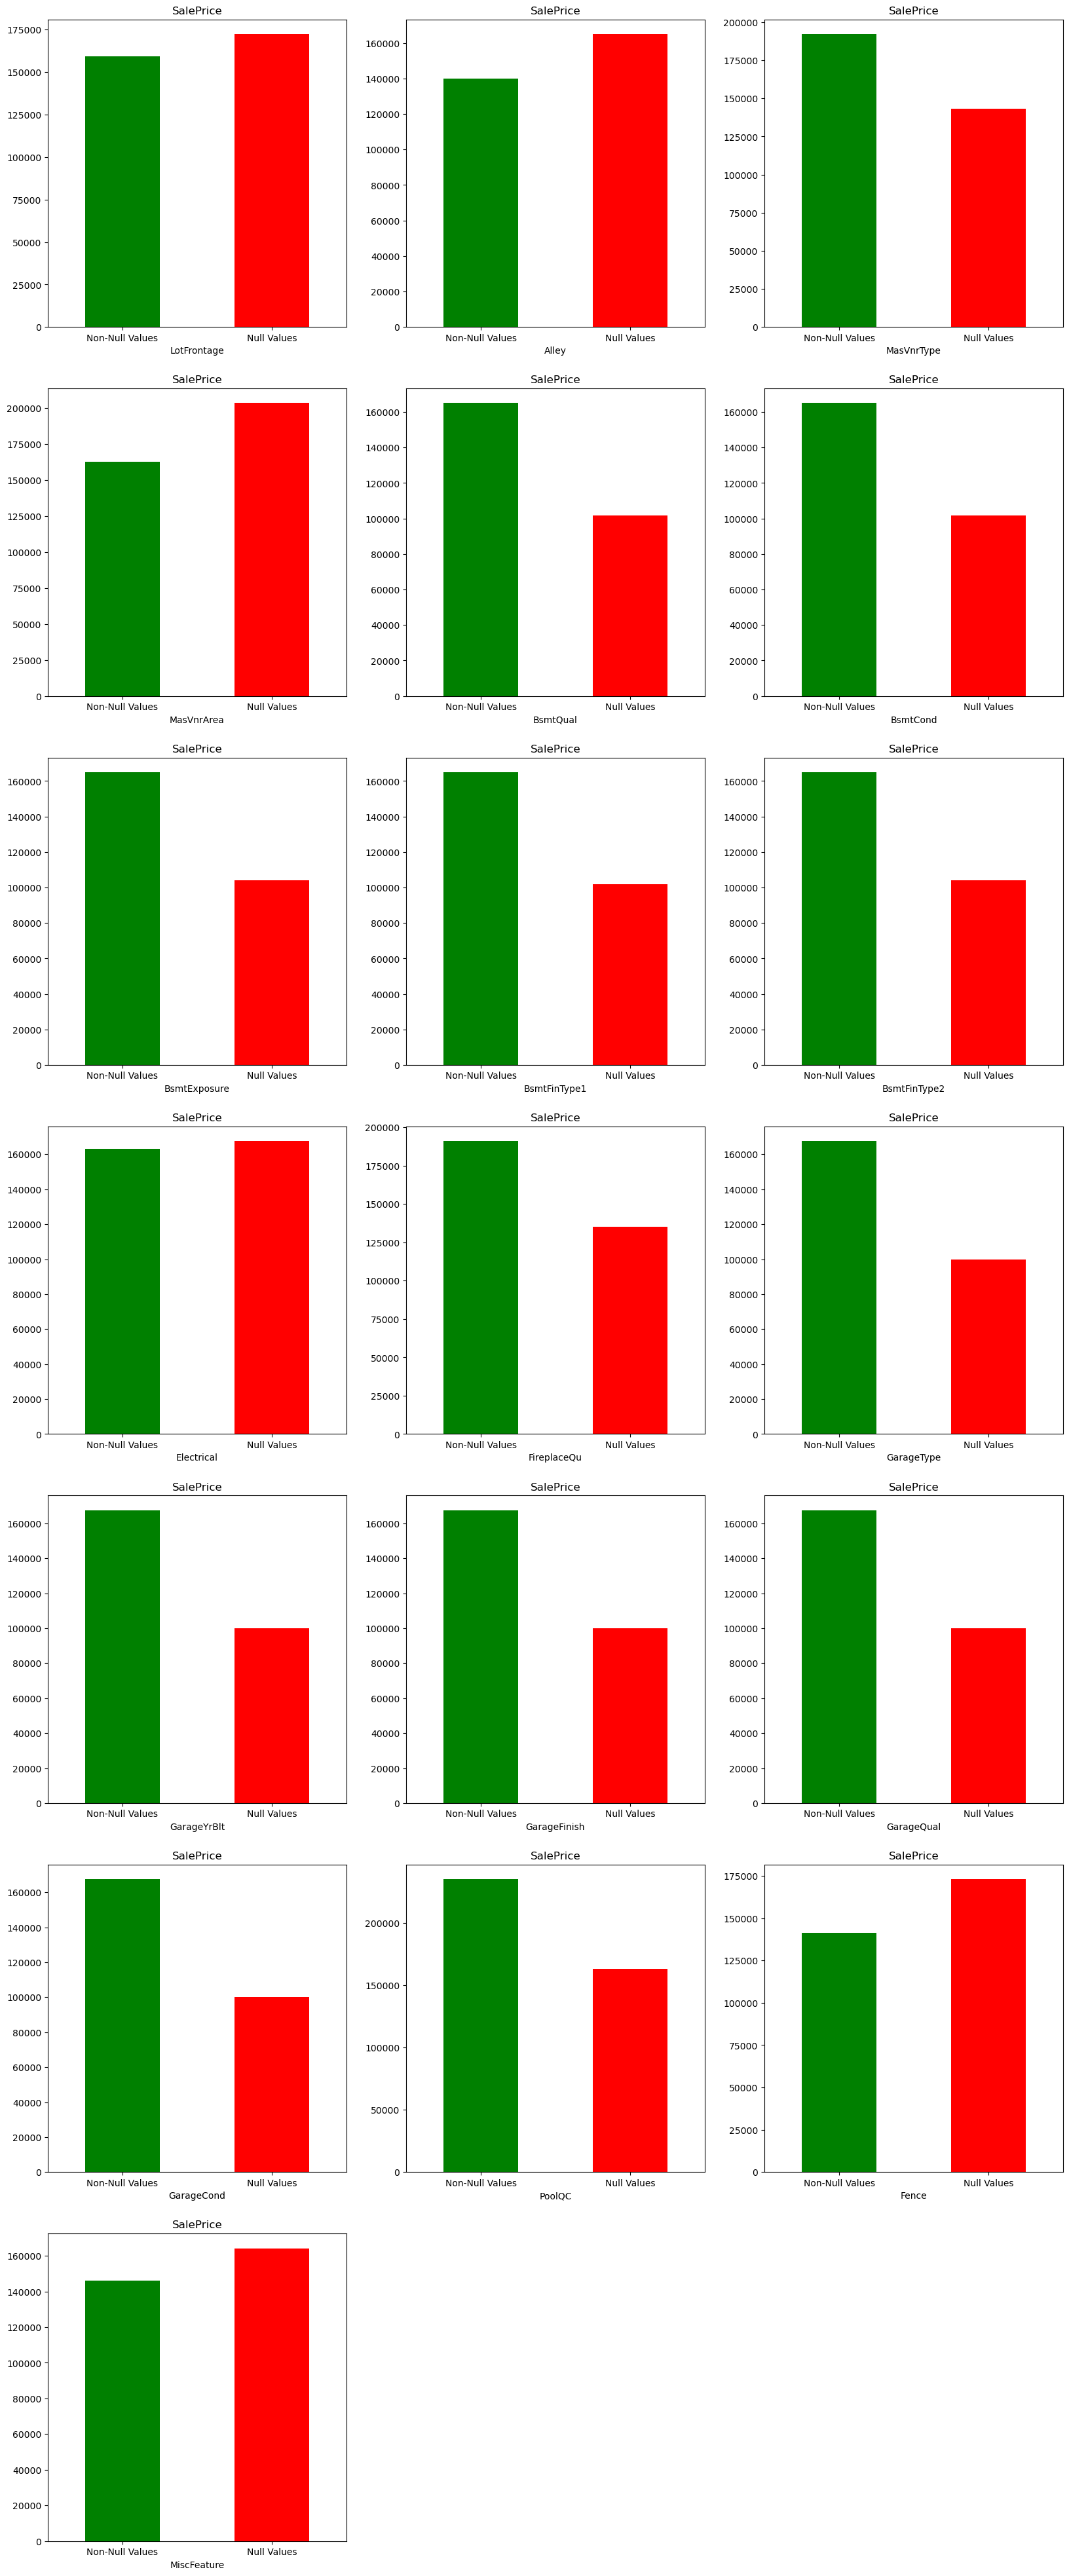

In [143]:
# Checking if NaN Values have any impact on the Sale Price or not
nan_col = []
for i in housing.columns:
    if housing[i].isnull().sum() > 0:
        nan_col.append(i)
housing_copy = housing.copy()    
fig,axs= plt.subplots(7,3,figsize=(20,50),squeeze=True)
for i,ax in zip(nan_col,axs.flatten()):    
    housing_copy[i] = np.where(housing_copy[i].isnull(), 'Null Values', 'Non-Null Values') 
    housing_copy.groupby(i)['SalePrice'].median().plot.bar(color = list('gr'),rot=0,ax=ax,subplots=True)
axs[6,1].set_axis_off()    
axs[6,2].set_axis_off() 
plt.show()

In [144]:
# Checking the number of numerical features and the number of categorical features
num_col = []
cat_col = []
for i in housing.columns:
    if housing[i].dtypes != 'O':
        num_col.append(i)
    else:
        cat_col.append(i)
print('There are', len(num_col) ,'numerical features')
print('There are', len(cat_col), 'categorical features')

There are 38 numerical features
There are 43 categorical features


Text(0.5, 1.0, 'House Price vs YearSold')

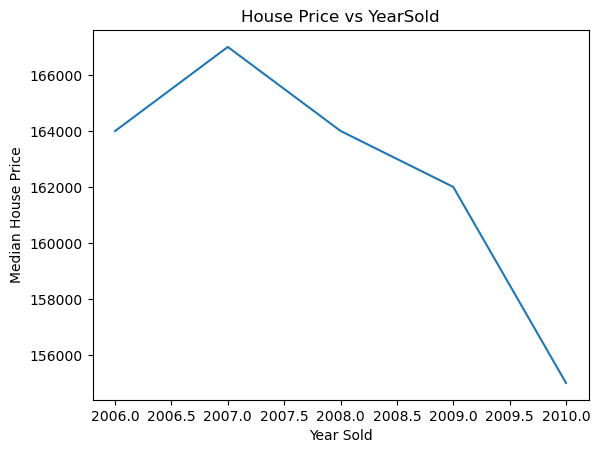

In [145]:
# Checking if the median price changes with the yr sold
housing['YrSold'] = housing['YrSold'].astype('int')
housing.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('Median House Price')
plt.title("House Price vs YearSold")

We can observe that average price reduced significantly from year 2007. Hence, the year in which the house was sold has a greater impact on the sale price.

Extract all "year" related columns in the dataset by understanding the data dictionary. Extracted the below columns.
- YearBuilt
- YearRemodAdd
- GarageYrBlt
- YrSold


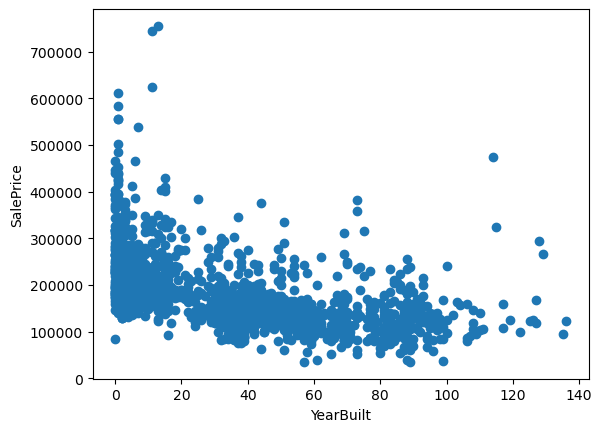

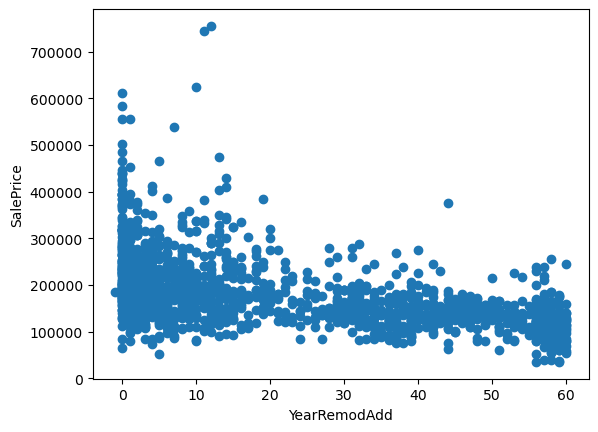

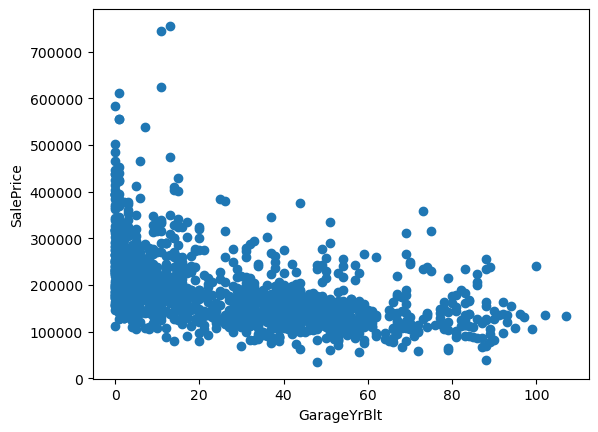

In [146]:
yr_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

# Comparing the Age of the Building / Renovated Building / Garage with the Price Sold
for feature in yr_cols:
    if feature!='YrSold':
        data=housing.copy()
        data[feature]=data['YrSold']-data[feature]
        plt.scatter(data[feature],data['SalePrice'])
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.show()

We can observe that SalePrice reduces as the property becomes old.

In [147]:
# Dropping ID Columns from dataset since it is not useful in the prediction usecase
housing.drop('Id', axis=1, inplace=True)

In [148]:
print(housing.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

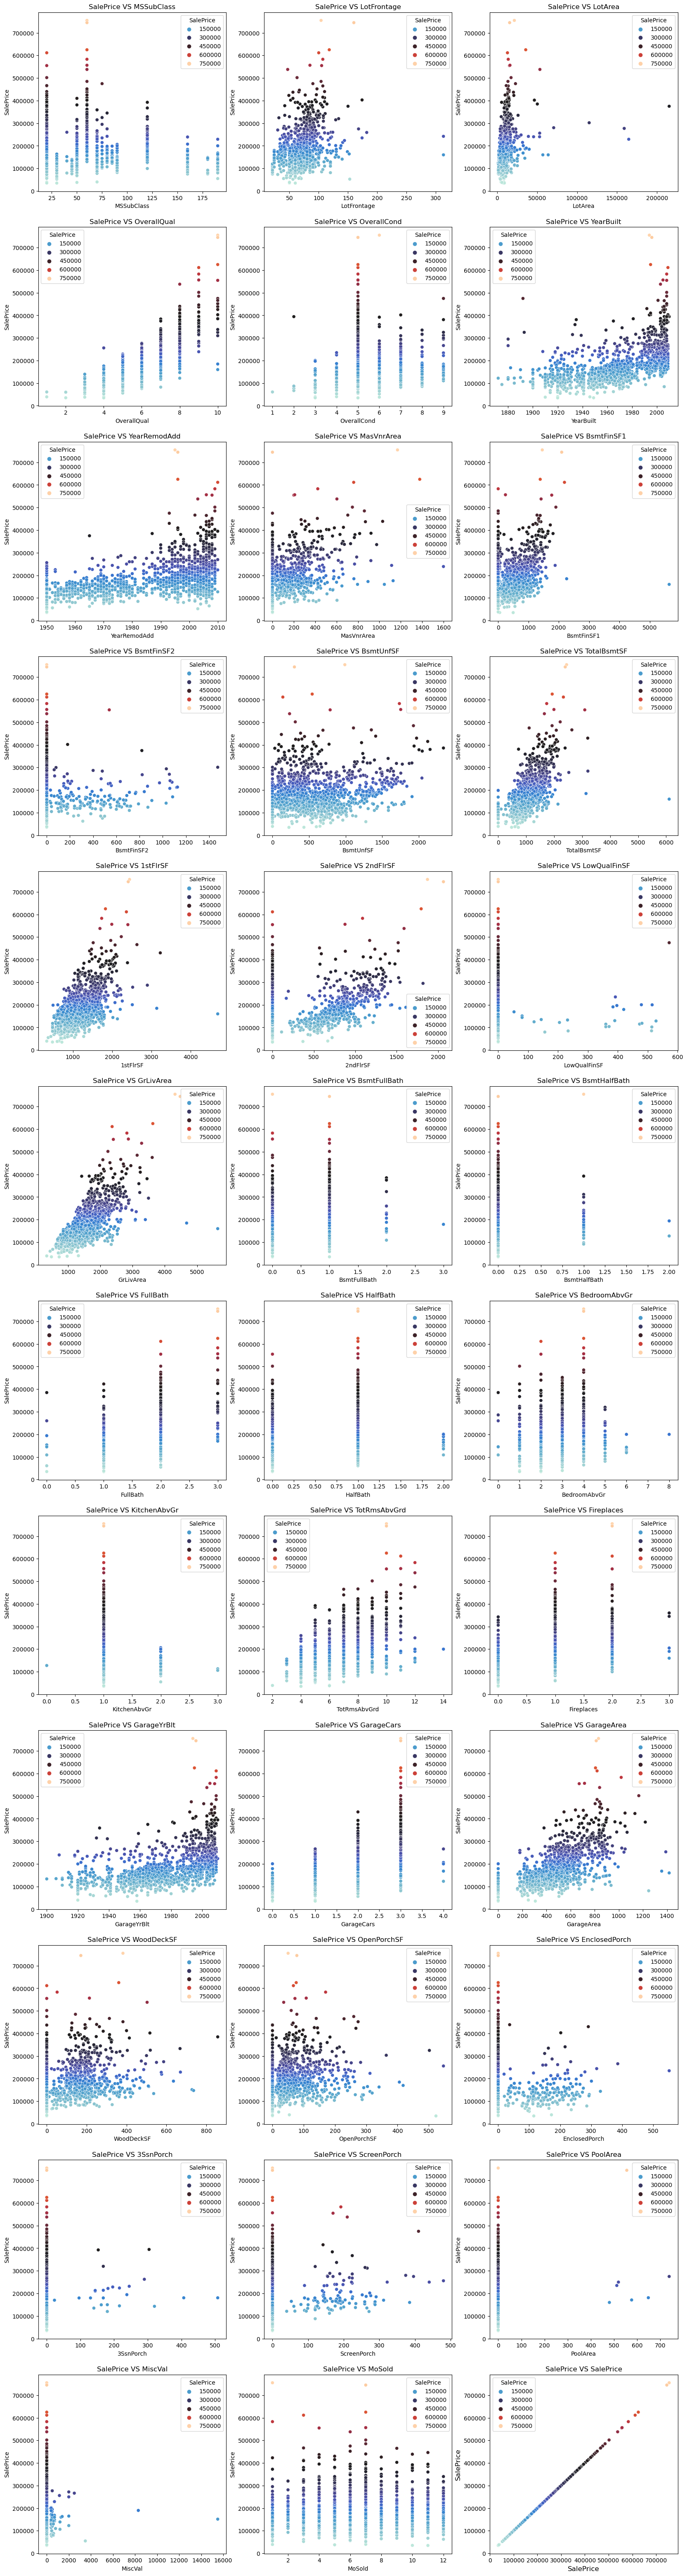

In [149]:
#Visualising numerical predictor variables with Target Variables
housing_num = housing.select_dtypes(include=['int64','float64'])
fig,axs= plt.subplots(12,3,figsize=(20,80))
for i,ax in zip(housing_num.columns,axs.flatten()):
    sns.scatterplot(x=i, y='SalePrice', hue='SalePrice',data=housing_num,ax=ax,palette='icefire')
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' VS '+str(i))

Observations:
    
- New properties are costlier than older properties.
- MasVnrArea is linearly related to the Price of the property.
- GRLiving Area has a direct corelation with the price of the property.
- Total basement area, which is linearly related with the total living area, size of 1st and 2nd floor also is directly proportional to the price of the property.
- Pool Area and Month sold has no effect on the price.

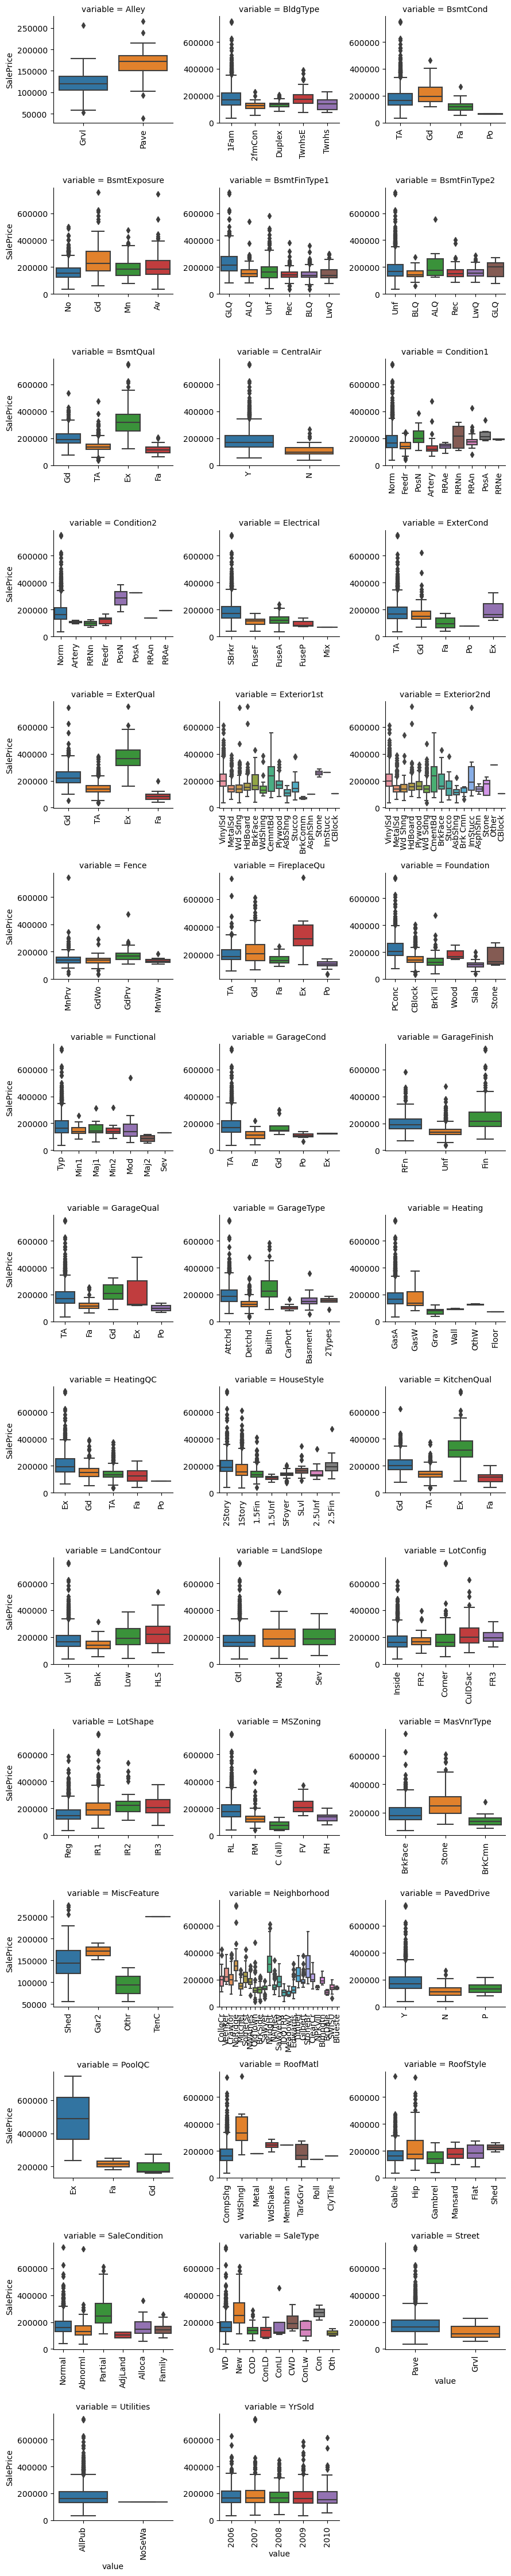

In [150]:
# Plotting Categorical Features with Sale Price
def facetgrid_boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
categorical = housing.select_dtypes(exclude=['int64','float64'])
f = pd.melt(housing, id_vars=['SalePrice'], value_vars=sorted(housing[categorical.columns]))
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False)
g = g.map(facetgrid_boxplot, "value", "SalePrice")

Observations:

There are a few outliers which we handle in the feature engineering section by capping them to a lower percentile. From the above box plots we see that:-

Paved alleys properties demand a higher price.
Houses where the basement quality is good and excellent are sold at higher prices compared to others.
Houses with good and excelent garages are sold at higher prices.
Houses with good quality kitchens also impact the price in a postive way.
Sale Prices does not have impact based on the year of sale.

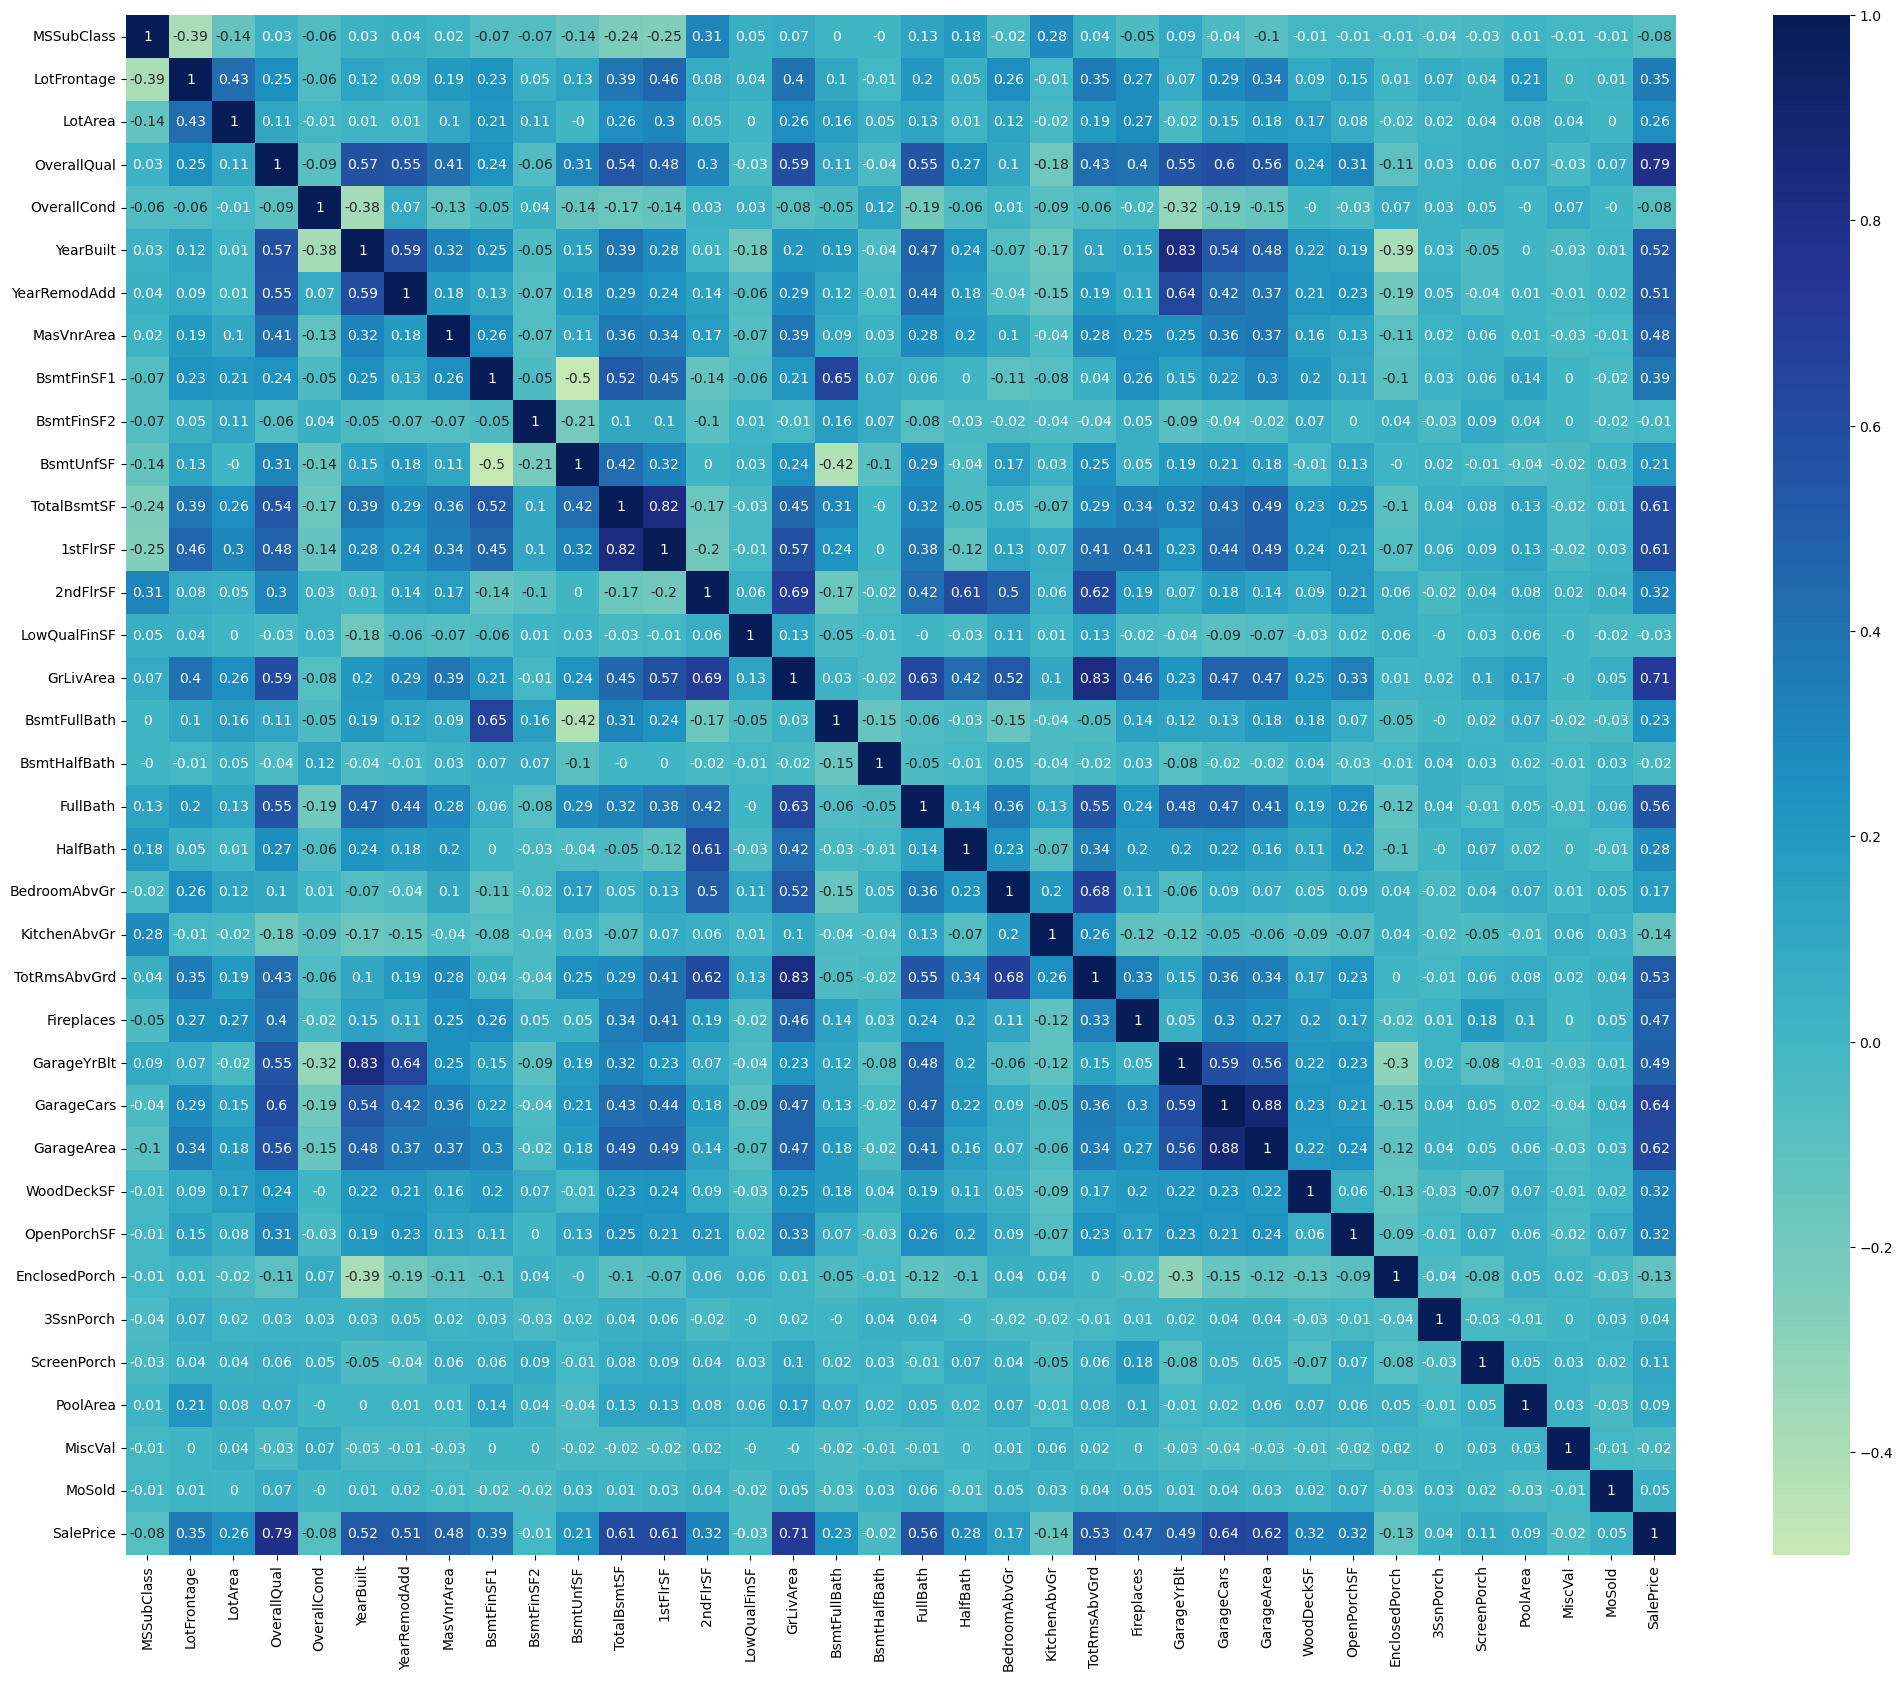

In [151]:
# Checking the corelation
plt.subplots(figsize = (25,20))
#Plotting heatmap of numerical features
sns.heatmap(round(housing_num.corr(),2), cmap='YlGnBu' , annot=True, center = 0)
plt.show()

Observations:
- Overall Quality followed by GrLivArea have high correlation (positive) with Sale Price.
- Kitchen above Gr followed by Enclosed Porch have high correlation (negative) with Sale Price.

- Correlation among independent variables:

Many independent variables are highly correlated. Thus, while building the model, we'll have to pay attention to multicollinearity.

## 2. Data Cleaning

Let's now conduct some data cleaning steps. 



In [152]:
# Creating a new Column to determine the age of the property
housing['age']=housing['YrSold']-housing['YearBuilt']
housing['garage_age'] = housing['YrSold'] - housing['GarageYrBlt']
housing['remodel_age'] = housing['YrSold'] - housing['YearRemodAdd']

In [153]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [154]:
housing.drop('GarageYrBlt',axis=1,inplace=True)

In [155]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

We need to convert some Numerical Columns to String columns since they are categorical variables. 

In [156]:
# Converting the Year to String since they are categorical features and should not be treated as numerical features
housing[['MSSubClass']] = housing[['MSSubClass']].astype(str) 
housing['YrSold'] = housing['YrSold'].astype(str)
housing['MoSold'] = housing['MoSold'].astype(str)
housing.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
0         60       RL         65.0     8450   Pave   NaN      Reg         Lvl   
1         20       RL         80.0     9600   Pave   NaN      Reg         Lvl   
2         60       RL         68.0    11250   Pave   NaN      IR1         Lvl   
3         70       RL         60.0     9550   Pave   NaN      IR1         Lvl   
4         60       RL         84.0    14260   Pave   NaN      IR1         Lvl   

  Utilities LotConfig  ... MiscFeature MiscVal MoSold YrSold SaleType  \
0    AllPub    Inside  ...         NaN       0      2   2008       WD   
1    AllPub       FR2  ...         NaN       0      5   2007       WD   
2    AllPub    Inside  ...         NaN       0      9   2008       WD   
3    AllPub    Corner  ...         NaN       0      2   2006       WD   
4    AllPub       FR2  ...         NaN       0     12   2008       WD   

  SaleCondition  SalePrice  age  garage_age  remodel_age  
0        Normal     208500    5         5.0            5  
1        Normal     181500   31        31.0           31  
2        Normal     223500    7         7.0            6  
3       Abnorml     140000   91         8.0           36  
4        Normal     250000    8         8.0            8  

[5 rows x 82 columns]

# Handling missing values
Instead of dropping rows or columns, we impute the NaN values with None, Default or similar values

In [157]:
# getting list of columns with Null Values again
print(round(housing.isnull().sum()/len(housing.index)*100,2).sort_values(ascending=False)[ round(housing.isnull().sum()/len(housing.index),2) > 0 ] )

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
MasVnrType      59.73
FireplaceQu     47.26
LotFrontage     17.74
GarageQual       5.55
GarageFinish     5.55
GarageCond       5.55
GarageType       5.55
garage_age       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtCond         2.53
BsmtQual         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
dtype: float64


In [158]:
#From the Data Description
#NA = No Pool for PoolQC
housing['PoolQC'] = housing['PoolQC'].fillna('None')
#NA = No Misc Feature for MiscFeature
housing['MiscFeature'] = housing['MiscFeature'].fillna('None')
#NA = No Alley
housing['Alley'] = housing['Alley'].fillna('None')
#NA = No Fireplace for FireplaceQu
housing['FireplaceQu'] = housing['FireplaceQu'].fillna('None')
#NA = No Fence
housing['Fence'] = housing['Fence'].fillna('None')
#NA = No Fireplace
housing['FireplaceQu'] = housing['FireplaceQu'].fillna('None')
#NA = No Garage
housing['GarageCond'] = housing['GarageCond'].fillna('None')
housing['GarageType'] = housing['GarageType'].fillna('None')
housing['GarageFinish'] = housing['GarageFinish'].fillna('None')
housing['GarageQual'] = housing['GarageQual'].fillna('None')
#No Garage No Age
housing['garage_age'] = housing['GarageQual'].fillna(0)   
#NA = No Basement
housing['BsmtExposure'] = housing['BsmtExposure'].fillna('None')
housing['BsmtFinType2'] = housing['BsmtFinType2'].fillna('None')
housing['BsmtCond'] = housing['BsmtCond'].fillna('None')
housing['BsmtQual'] = housing['BsmtQual'].fillna('None')
housing['BsmtFinType1'] = housing['BsmtFinType1'].fillna('None')
#NA = No Masonery Area
housing['MasVnrType'] = housing['MasVnrType'].fillna('None')
housing['MasVnrArea'] = housing['MasVnrArea'].fillna(0)

In [159]:
# getting list of columns with Null Values again
print(round(housing.isnull().sum()/len(housing.index)*100,2).sort_values(ascending=False)[ round(housing.isnull().sum()/len(housing.index),2) > 0 ] )

LotFrontage    17.74
dtype: float64


In [160]:
#LotFrontage : Replacing Null value with the median of the neighbourhood
housing['LotFrontage'] = housing.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [161]:
# getting list of columns with Null Values again
print(round(housing.isnull().sum()/len(housing.index)*100,2).sort_values(ascending=False)[ round(housing.isnull().sum()/len(housing.index),2) > 0 ] )

Series([], dtype: float64)


In [162]:
round(housing.isnull().sum()/len(housing.index)*100,5).sort_values(ascending=False)[ round(housing.isnull().sum()/len(housing.index),5) > 0 ]

Electrical    0.06849
dtype: float64

In [163]:
# Filling the Electrical 0.06% rows with the mode
housing['Electrical'] = housing['Electrical'].fillna(housing['Electrical'].mode()[0])

In [164]:
round(housing.isnull().sum()/len(housing.index)*100,5).sort_values(ascending=False)

MSSubClass      0.0
GarageQual      0.0
GarageCars      0.0
GarageFinish    0.0
GarageType      0.0
               ... 
ExterQual       0.0
MasVnrArea      0.0
MasVnrType      0.0
Exterior2nd     0.0
remodel_age     0.0
Length: 82, dtype: float64

All missing values are updated and good now

In [165]:
housing.describe()

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     70.199658   10516.828082     6.099315     5.575342  1971.267808   
std      22.431902    9981.264932     1.382997     1.112799    30.202904   
min      21.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      60.000000    7553.500000     5.000000     5.000000  1954.000000   
50%      70.000000    9478.500000     6.000000     5.000000  1973.000000   
75%      80.000000   11601.500000     7.000000     6.000000  2000.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count   1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean    1984.865753   103.117123   443.639726    46.549315   567.240411  ...   
std       20.645407   180.731373   456.098091   161.319273   441.866955  ...   
min     1950.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     1967.000000     0.000000     0.000000     0.000000   223.000000  ...   
50%     1994.000000     0.000000   383.500000     0.000000   477.500000  ...   
75%     2004.000000   164.250000   712.250000     0.000000   808.000000  ...   
max     2010.000000  1600.000000  5644.000000  1474.000000  2336.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal      SalePrice          age  remodel_age  
count  1460.000000   1460.000000    1460.000000  1460.000000  1460.000000  
mean      2.758904     43.489041  180921.195890    36.547945    22.950000  
std      40.177307    496.123024   79442.502883    30.250152    20.640653  
min       0.000000      0.000000   34900.000000     0.000000    -1.000000  
25%       0.000000      0.000000  129975.000000     8.000000     4.000000  
50%       0.000000      0.000000  163000.000000    35.000000    14.000000  
75%       0.000000      0.000000  214000.000000    54.000000    41.000000  
max     738.000000  15500.000000  755000.000000   136.000000    60.000000  

[8 rows x 35 columns]

In [166]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [38]:
housing.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
0         60       RL         65.0     8450   Pave  None      Reg         Lvl   
1         20       RL         80.0     9600   Pave  None      Reg         Lvl   
2         60       RL         68.0    11250   Pave  None      IR1         Lvl   
3         70       RL         60.0     9550   Pave  None      IR1         Lvl   
4         60       RL         84.0    14260   Pave  None      IR1         Lvl   

  Utilities LotConfig  ... MiscFeature MiscVal MoSold YrSold SaleType  \
0    AllPub    Inside  ...        None       0      2   2008       WD   
1    AllPub       FR2  ...        None       0      5   2007       WD   
2    AllPub    Inside  ...        None       0      9   2008       WD   
3    AllPub    Corner  ...        None       0      2   2006       WD   
4    AllPub       FR2  ...        None       0     12   2008       WD   

  SaleCondition  SalePrice  age  garage_age  remodel_age  
0        Normal     208500    5          TA            5  
1        Normal     181500   31          TA           31  
2        Normal     223500    7          TA            6  
3       Abnorml     140000   91          TA           36  
4        Normal     250000    8          TA            8  

[5 rows x 82 columns]

In [167]:
print(housing['Utilities'].value_counts())
print(housing['Street'].value_counts())
print(housing['PoolQC'].value_counts())

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
Street
Pave    1454
Grvl       6
Name: count, dtype: int64
PoolQC
None    1453
Gd         3
Ex         2
Fa         2
Name: count, dtype: int64


In [168]:
# Trying to remove redundant features
def redundant_feature(housing):
    redundant = []
    for i in housing.columns:
        counts = housing[i].value_counts()
        count_max = counts.iloc[0]
        if count_max / len(housing) * 100 > 99:
            redundant.append(i)
    redundant = list(redundant)
    return redundant

In [169]:
redundant_features = redundant_feature(housing)
redundant_features

['Street', 'Utilities', 'PoolArea', 'PoolQC']

Dropping these features since they have more than 99% of a single category and thus play no part in the predicting the target variable

In [170]:
housing.shape

(1460, 82)

In [171]:
housing.drop(redundant_features,axis=1,inplace=True)

housing.shape

(1460, 78)

In [172]:
# Removing outliers to make the model more robust
# From EDA we see that Living Area, Garage Area, Basement Area and Lot Area. Removing outliers from these. Other outliers will be handled 
# during power transform
def drop_outliers(x):
    list = []
    outl_col = ['GrLivArea','GarageArea','TotalBsmtSF','LotArea']
    for col in outl_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x  

In [173]:
housing = drop_outliers(housing)
housing.shape

(1455, 78)

In [174]:
# Creating some new features based on the existing features

#Vintage house with remodified version of it plays a important role in prediction(i.e. high price )
housing['YrBltAndRemod']=housing['YearBuilt']+housing['YearRemodAdd']
#Overall area for all floors and basement plays an important role, hence creating total area in square foot column
housing['Total_sqr_footage'] = (housing['BsmtFinSF1'] + housing['BsmtFinSF2'] + housing['1stFlrSF'] + housing['2ndFlrSF'])
# Creating derived column for total number of bathrooms column
housing['Total_Bathrooms'] = (housing['FullBath'] + (0.5 * housing['HalfBath']) + housing['BsmtFullBath'] + (0.5 * housing['BsmtHalfBath']))
#Creating derived column for total porch area 
housing['Total_porch_sf'] = (housing['OpenPorchSF'] + housing['3SsnPorch'] + housing['EnclosedPorch'] + housing['ScreenPorch'] + housing['WoodDeckSF'])

In [175]:
housing.head()

MSSubClass MSZoning  LotFrontage  LotArea Alley LotShape LandContour  \
0         60       RL         65.0     8450  None      Reg         Lvl   
1         20       RL         80.0     9600  None      Reg         Lvl   
2         60       RL         68.0    11250  None      IR1         Lvl   
3         70       RL         60.0     9550  None      IR1         Lvl   
4         60       RL         84.0    14260  None      IR1         Lvl   

  LotConfig LandSlope Neighborhood  ... SaleType SaleCondition SalePrice age  \
0    Inside       Gtl      CollgCr  ...       WD        Normal    208500   5   
1       FR2       Gtl      Veenker  ...       WD        Normal    181500  31   
2    Inside       Gtl      CollgCr  ...       WD        Normal    223500   7   
3    Corner       Gtl      Crawfor  ...       WD       Abnorml    140000  91   
4       FR2       Gtl      NoRidge  ...       WD        Normal    250000   8   

   garage_age  remodel_age  YrBltAndRemod  Total_sqr_footage Total_Bathrooms  \
0          TA            5           4006               2416             3.5   
1          TA           31           3952               2240             2.5   
2          TA            6           4003               2272             3.5   
3          TA           36           3885               1933             2.0   
4          TA            8           4000               2853             3.5   

  Total_porch_sf  
0             61  
1            298  
2             42  
3            307  
4            276  

[5 rows x 82 columns]

In [176]:
housing.shape

(1455, 82)

In [177]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1455 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1455 non-null   object 
 1   MSZoning           1455 non-null   object 
 2   LotFrontage        1455 non-null   float64
 3   LotArea            1455 non-null   int64  
 4   Alley              1455 non-null   object 
 5   LotShape           1455 non-null   object 
 6   LandContour        1455 non-null   object 
 7   LotConfig          1455 non-null   object 
 8   LandSlope          1455 non-null   object 
 9   Neighborhood       1455 non-null   object 
 10  Condition1         1455 non-null   object 
 11  Condition2         1455 non-null   object 
 12  BldgType           1455 non-null   object 
 13  HouseStyle         1455 non-null   object 
 14  OverallQual        1455 non-null   int64  
 15  OverallCond        1455 non-null   int64  
 16  YearBuilt          1455 non-n

In [178]:
#Creating Dummy Variables for Categorical Columns
num_col=[]
cat_col=[]
for i in housing.columns:
    if housing[i].dtypes != 'O':
        num_col.append(i)
    else:
        cat_col.append(i)

In [179]:
housing_dummy= pd.get_dummies(housing[cat_col], dtype=int)   
housing=pd.concat([housing,housing_dummy],axis=1)

In [180]:
housing.head()

MSSubClass MSZoning  LotFrontage  LotArea Alley LotShape LandContour  \
0         60       RL         65.0     8450  None      Reg         Lvl   
1         20       RL         80.0     9600  None      Reg         Lvl   
2         60       RL         68.0    11250  None      IR1         Lvl   
3         70       RL         60.0     9550  None      IR1         Lvl   
4         60       RL         84.0    14260  None      IR1         Lvl   

  LotConfig LandSlope Neighborhood  ... SaleCondition_Alloca  \
0    Inside       Gtl      CollgCr  ...                    0   
1       FR2       Gtl      Veenker  ...                    0   
2    Inside       Gtl      CollgCr  ...                    0   
3    Corner       Gtl      Crawfor  ...                    0   
4       FR2       Gtl      NoRidge  ...                    0   

  SaleCondition_Family SaleCondition_Normal SaleCondition_Partial  \
0                    0                    1                     0   
1                    0                    1                     0   
2                    0                    1                     0   
3                    0                    0                     0   
4                    0                    1                     0   

   garage_age_Ex  garage_age_Fa  garage_age_Gd  garage_age_None garage_age_Po  \
0              0              0              0                0             0   
1              0              0              0                0             0   
2              0              0              0                0             0   
3              0              0              0                0             0   
4              0              0              0                0             0   

  garage_age_TA  
0             1  
1             1  
2             1  
3             1  
4             1  

[5 rows x 377 columns]

In [181]:
housing= housing.drop(cat_col,axis=1)        

In [182]:
housing.head()

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0         65.0     8450            7            5       2003          2003   
1         80.0     9600            6            8       1976          1976   
2         68.0    11250            7            5       2001          2002   
3         60.0     9550            7            5       1915          1970   
4         84.0    14260            8            5       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleCondition_Alloca  \
0       196.0         706           0        150  ...                     0   
1         0.0         978           0        284  ...                     0   
2       162.0         486           0        434  ...                     0   
3         0.0         216           0        540  ...                     0   
4       350.0         655           0        490  ...                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  \
0                     0                     1                      0   
1                     0                     1                      0   
2                     0                     1                      0   
3                     0                     0                      0   
4                     0                     1                      0   

   garage_age_Ex  garage_age_Fa  garage_age_Gd  garage_age_None  \
0              0              0              0                0   
1              0              0              0                0   
2              0              0              0                0   
3              0              0              0                0   
4              0              0              0                0   

   garage_age_Po  garage_age_TA  
0              0              1  
1              0              1  
2              0              1  
3              0              1  
4              0              1  

[5 rows x 333 columns]

In [183]:
housing1 = housing

In [184]:
housing1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1455 entries, 0 to 1459
Columns: 333 entries, LotFrontage to garage_age_TA
dtypes: float64(3), int32(295), int64(35)
memory usage: 2.1 MB


In [185]:
housing1.shape

(1455, 333)

## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [186]:
# split into X and y

X = housing1.drop('SalePrice',axis=1) # predictors in variable X
y = housing1['SalePrice'] # response variable

In [187]:
# Checking co-related features
corr = X.corr()
corr1 = corr[abs(corr)>=.6]
corr2 =  corr.where(~np.tril(np.ones(corr.shape)).astype(bool))  #To remove repetition and 1 correlations
corr_result = corr2.stack()
print(corr_result[(abs(corr_result) > 0.6)])


OverallQual           GarageCars               0.602025
                      YrBltAndRemod            0.628465
                      ExterQual_TA            -0.647338
YearBuilt             age                     -0.999036
                      YrBltAndRemod            0.931280
                                                 ...   
SaleType_New          SaleCondition_Partial    0.986718
SaleType_WD           SaleCondition_Normal     0.632805
                      SaleCondition_Partial   -0.768294
SaleCondition_Normal  SaleCondition_Partial   -0.652835
garage_age_None       garage_age_TA           -0.718832
Length: 165, dtype: float64


In [188]:
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'garage_age_Ex', 'garage_age_Fa',
       'garage_age_Gd', 'garage_age_None', 'garage_age_Po', 'garage_age_TA'],
      dtype='object', length=332)

In [189]:
# Let's copy the variables to X1 and use it for further processing
X1 = X

In [190]:
X1.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'garage_age_Ex', 'garage_age_Fa',
       'garage_age_Gd', 'garage_age_None', 'garage_age_Po', 'garage_age_TA'],
      dtype='object', length=332)

In [193]:
X1.shape

(1455, 332)

In [194]:
X1.drop(['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
        '1stFlrSF','2ndFlrSF','GrLivArea','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageCars',
        'WoodDeckSF','YrBltAndRemod','Total_Bathrooms','MSSubClass_120','MSSubClass_160','MSSubClass_190','MSSubClass_20',
        'MSSubClass_45','MSSubClass_50','MSSubClass_60','MSSubClass_75','MSSubClass_80','MSSubClass_85','MSSubClass_90',
        'MSZoning_FV','MSZoning_RL','Alley_Grvl','Alley_None','LotShape_IR1','LandContour_Bnk','LotConfig_Corner',
        'LandSlope_Gtl','Neighborhood_NPkVill','Condition1_Feedr','Condition2_Feedr','Condition2_RRAe','BldgType_1Fam',
        'HouseStyle_1Story','RoofStyle_Flat','RoofStyle_Gable','RoofMatl_CompShg','Exterior2nd_AsbShng','Exterior2nd_BrkFace',
        'Exterior2nd_CBlock','Exterior2nd_CmentBd','Exterior2nd_HdBoard','Exterior2nd_MetalSd','Exterior2nd_Plywood',
        'Exterior2nd_Stucco','Exterior2nd_VinylSd','Exterior2nd_Wd Sdng','MasVnrType_None','ExterQual_Gd','ExterQual_TA',
        'ExterCond_Gd','Foundation_CBlock','Foundation_Slab','BsmtQual_Gd','BsmtQual_None','BsmtCond_Gd','BsmtCond_None',
        'BsmtCond_Po','BsmtExposure_None','BsmtFinType1_None','Heating_GasA','HeatingQC_Ex','CentralAir_N','Electrical_FuseA',
        'KitchenQual_Gd','GarageType_Attchd','GarageType_None','GarageFinish_None','GarageQual_Ex','GarageQual_Fa',
        'GarageQual_Gd','GarageQual_None','GarageQual_Po','GarageQual_TA','GarageCond_Ex','GarageCond_None','GarageCond_Po',
        'GarageCond_TA','PavedDrive_N','Fence_None','MiscFeature_None','SaleType_New','SaleType_WD','SaleCondition_Normal',
        'Foundation_PConc','MiscFeature_Gar2','Foundation_PConc','garage_age_None'],
         axis=1,inplace=True)

In [195]:
# Checking the shape after dropping all co-related columns
X1.shape

(1455, 234)

In [196]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=0.7, test_size=0.3, random_state=100)

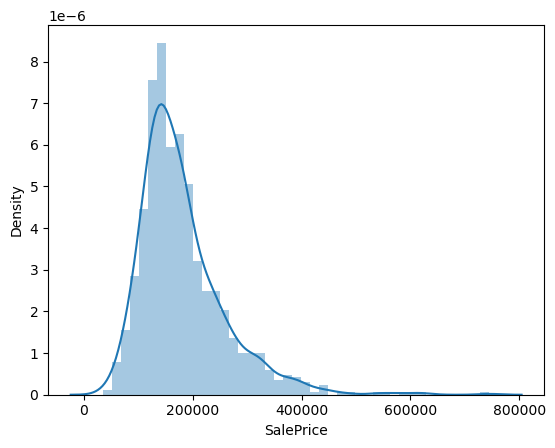

In [197]:
#Distribution of Target Variable
sns.distplot(y_train)
plt.show()

The Data is right-skewed. Thus we transform it to make it more gaussian.

In [198]:
#Transforming the Target feature to make the data gaussian
pt = PowerTransformer(method='box-cox', standardize=False)
y_train = pt.fit_transform(y_train.to_frame())
y_test = pt.transform(y_test.to_frame())

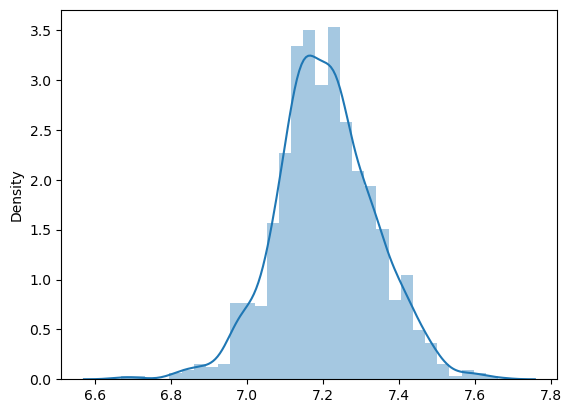

In [199]:
sns.distplot(y_train)
plt.show()

The target variable is now transformed.

In [200]:
# Scaling the data using a Minmax Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = DataFrame(X_train)
X_train.columns = X1.columns
X_test = scaler.transform(X_test)
X_test = DataFrame(X_test)
X_test.columns = X1.columns

In [201]:
X_train.head()

LotFrontage   LotArea  OverallCond  LowQualFinSF  BsmtFullBath  \
0     0.092466  0.081413     0.428571           0.0           0.0   
1     0.195205  0.093578     0.571429           0.0           0.0   
2     0.236301  0.159485     0.428571           0.0           0.5   
3     0.184932  0.124343     0.714286           0.0           0.5   
4     0.147260  0.086581     0.428571           0.0           0.5   

   BsmtHalfBath  TotRmsAbvGrd  GarageArea  OpenPorchSF  EnclosedPorch  ...  \
0           0.0           0.4    0.341007     0.069721            0.0  ...   
1           0.0           0.5    0.175540     0.195219            0.0  ...   
2           0.0           0.6    0.509353     0.348606            0.0  ...   
3           0.0           0.5    0.345324     0.000000            0.0  ...   
4           0.0           0.4    0.454676     0.000000            0.0  ...   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                    0.0                    0.0                   0.0   
1                    0.0                    0.0                   0.0   
2                    0.0                    0.0                   0.0   
3                    0.0                    0.0                   0.0   
4                    0.0                    0.0                   0.0   

   SaleCondition_Family  SaleCondition_Partial  garage_age_Ex  garage_age_Fa  \
0                   0.0                    1.0            0.0            0.0   
1                   0.0                    0.0            0.0            0.0   
2                   0.0                    0.0            0.0            0.0   
3                   0.0                    0.0            0.0            0.0   
4                   0.0                    0.0            0.0            0.0   

   garage_age_Gd  garage_age_Po  garage_age_TA  
0            0.0            0.0            1.0  
1            0.0            0.0            1.0  
2            0.0            0.0            1.0  
3            0.0            0.0            1.0  
4            0.0            0.0            1.0  

[5 rows x 234 columns]

## 4. Model Building and Evaluation

## Ridge and Lasso Regression

Let's now try predicting sale prices by performing ridge and lasso regression.

### Ridge Regression

Fitting 11 folds for each of 28 candidates, totalling 308 fits


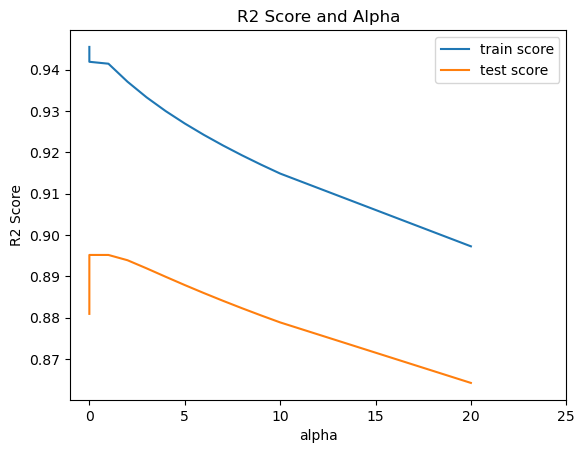

The optimum alpha is 0
The R2 Score of the model on the test dataset for optimum alpha is -1.0013556662704416e+27
The MSE of the model on the test dataset for optimum alpha is 1.6750878534917735e+25


In [246]:
# Using RFE to find top 300 variables
rfe = RFE(estimator=Ridge(), n_features_to_select=300)
rfe = rfe.fit(X_train,y_train)
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_test_rfe = X_test[col]

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()

# cross validation
folds = 11
model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=30]
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,30,5))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
ridge_final = Ridge(alpha=alpha)
ridge_final.fit(X_train_rfe,y_train)
ridge_coef = ridge_final.coef_
y_test_pred = ridge_final.predict(X_test_rfe)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

In [247]:
# Checking the VIF
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
high_vif = vif[vif['VIF']>10]
high_vif

Features    VIF
233         garage_age_TA    inf
171       Functional_Min2    inf
98    Exterior1st_BrkComm    inf
97    Exterior1st_AsphShn    inf
96    Exterior1st_AsbShng    inf
..                    ...    ...
56   Neighborhood_SawyerW  18.50
48   Neighborhood_Mitchel  16.62
43   Neighborhood_Crawfor  14.62
46    Neighborhood_IDOTRR  14.39
51   Neighborhood_NoRidge  13.54

[85 rows x 2 columns]

In [248]:
# Dropping cols with high VIF
X_train_rfe2 = X_train_rfe.drop(high_vif.Features,axis=1)
X_test_rfe2 = X_test_rfe.drop(high_vif.Features,axis=1)

Now we have all the columns which do not suffer from multicolinearity

Fitting 11 folds for each of 28 candidates, totalling 308 fits


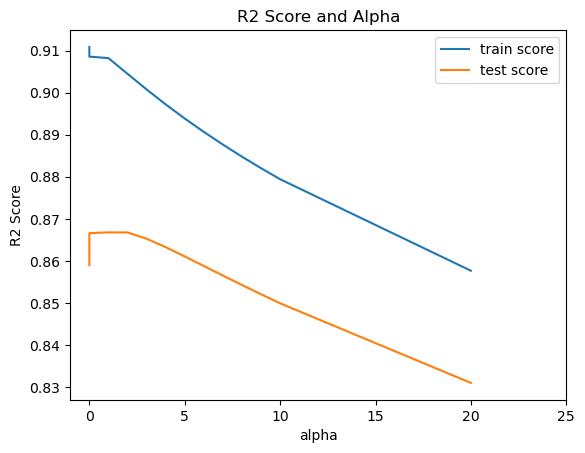

The optimum alpha is 1
The R2 Score of the model on the test dataset for optimum alpha is 0.8149214029155637
The MSE of the model on the test dataset for optimum alpha is 0.0030960319131375213


In [249]:
# Building the Ridge Model again
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge(random_state=100)

# cross validation
folds = 11
model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe2, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=30]
# plotting mean test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,30,5))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
ridge_final2 = Ridge(alpha=alpha,random_state=100)
ridge_final2.fit(X_train_rfe2,y_train)
ridge_coef2 = ridge_final2.coef_
y_train_pred = ridge_final2.predict(X_train_rfe2)
y_test_pred = ridge_final2.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

In [250]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

metric2 = []
r2_train_lr = r2_score(y_train, y_train_pred)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_test_pred)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_train_pred))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_test_pred))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_train_pred)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_test_pred)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9070046459793643
0.8149214029155637
1.569313669222709
1.3529659460410968
0.0015415654903955885
0.0030960319131375213


In [251]:
#Displaying the co-efficients of the model
ridge_coeff2 = pd.DataFrame(np.atleast_2d(ridge_coef2),columns=X_train_rfe2.columns)
ridge_coeff2 = ridge_coeff2.T
ridge_coeff2.rename(columns={0: 'Ridge Co-Efficient'},inplace=True)
ridge_coeff2.sort_values(by=['Ridge Co-Efficient'], ascending=False,inplace=True)
ridge_coeff2.head(20)

Ridge Co-Efficient
Total_sqr_footage               0.296077
GarageArea                      0.140291
TotRmsAbvGrd                    0.100695
LotArea                         0.072104
OverallCond                     0.063949
LotFrontage                     0.051675
Total_porch_sf                  0.040448
SaleType_Con                    0.040012
CentralAir_Y                    0.039645
Neighborhood_StoneBr            0.039182
RoofMatl_WdShngl                0.036583
HouseStyle_2.5Unf               0.033854
SaleType_ConLD                  0.033250
Alley_Pave                      0.032378
SaleType_Oth                    0.031312
MSSubClass_70                   0.030947
HouseStyle_1.5Unf               0.029068
PavedDrive_P                    0.028914
SaleType_CWD                    0.027989
KitchenQual_Ex                  0.027050

The Top 20 features impacting the price of the property is stated above.

### Lasso Regression

In [252]:

# Creating a model with an arbitrary alpha to understand the value ranges
lasso1 = Lasso(alpha=0.0001)        
lasso1.fit(X_train_rfe2, y_train) 

y_test_pred = lasso1.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for 0.0001 alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

The R2 Score of the model on the test dataset for 0.0001 alpha is 0.8196520492891395
The MSE of the model on the test dataset for optimum alpha is 0.003016896711266085


Fitting 11 folds for each of 11 candidates, totalling 121 fits


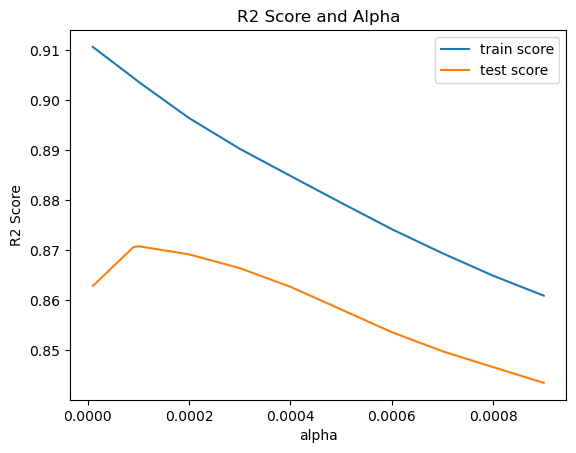

The optimum alpha is 0.0001
The R2 Score of the model on the test dataset for optimum alpha is 0.8196520492891395
The MSE of the model on the test dataset for optimum alpha is 0.003016896711266085


In [253]:
# Building a Lasso Model with GridSearch CV to find the optimum alpha
params = {'alpha': [0.00001, 0.00009, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009 ]}
lasso = Lasso(random_state=100)

# cross validation
folds = 11
model_cv = GridSearchCV(estimator = lasso, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe2, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
lasso_final2 = Lasso(alpha=alpha,random_state=100)
lasso_final2.fit(X_train_rfe2,y_train)
lasso_coef2 = lasso_final2.coef_
y_train_pred = lasso_final2.predict(X_train_rfe2)
y_test_pred = lasso_final2.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

In [254]:
# Lets calculate some Lasso metrics such as R2 score, RSS and RMSE

metric3 = []
r2_train_lr = r2_score(y_train, y_train_pred)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_test_pred)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_train_pred))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_test_pred))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_train_pred)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_test_pred)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9023080383846847
0.8196520492891395
32245.502515246222
6069.711025208059
0.001619420220517712
0.003016896711266085


In [255]:
#Displaing the co-efficients of the model
lasso_coeff2 = pd.DataFrame(np.atleast_2d(lasso_coef2),columns=X_train_rfe2.columns)
lasso_coeff2 = lasso_coeff2.T
lasso_coeff2.rename(columns={0: "Lasso Co-Efficient"},inplace=True)
lasso_coeff2.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
lasso_coeff2.head(20)

Lasso Co-Efficient
Total_sqr_footage               0.356373
GarageArea                      0.141185
TotRmsAbvGrd                    0.089021
LotArea                         0.069844
OverallCond                     0.056803
CentralAir_Y                    0.041392
Total_porch_sf                  0.038793
LotFrontage                     0.032122
Neighborhood_StoneBr            0.031788
MSSubClass_70                   0.028251
Alley_Pave                      0.026893
OpenPorchSF                     0.025515
HouseStyle_2.5Unf               0.023612
KitchenQual_Ex                  0.023475
PavedDrive_P                    0.021827
BsmtQual_Ex                     0.021777
SaleType_ConLD                  0.021359
LandContour_HLS                 0.020659
PavedDrive_Y                    0.019646
MasVnrType_Stone                0.018687

The top 20 features of the final Lasso model is stated above.

### The Final Ridge Regression Model is as follows:-

In [256]:
ridge_final2

Ridge(alpha=1, random_state=100)

### The Final Lasso Regression Model is as follows:-

In [257]:
lasso_final2

Lasso(alpha=0.0001, random_state=100)

In [259]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Ridge Regression': metric2,
        'Lasso Regression': metric3   
        }
lr_table

{'Metric': ['R2 Score (Train)',
  'R2 Score (Test)',
  'RSS (Train)',
  'RSS (Test)',
  'MSE (Train)',
  'MSE (Test)'],
 'Ridge Regression': [0.9070046459793643,
  0.8149214029155637,
  1.569313669222709,
  1.3529659460410968,
  0.03926277486876836,
  0.05564199774574526],
 'Lasso Regression': [0.9023080383846847,
  0.8196520492891395,
  32245.502515246222,
  6069.711025208059,
  0.040242020581945336,
  0.054926284338794346]}

In [261]:
final_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Ridge Regression', 'Lasso Regression'] )
final_metric

Metric  Ridge Regression  Lasso Regression
0  R2 Score (Train)          0.907005          0.902308
1   R2 Score (Test)          0.814921          0.819652
2       RSS (Train)          1.569314      32245.502515
3        RSS (Test)          1.352966       6069.711025
4       MSE (Train)          0.039263          0.040242
5        MSE (Test)          0.055642          0.054926

## Conclusion:

R2 score of approx 0.81 is achieved on both Ridge and Lasso Models. The following factors mostly influence the house price as demonstrated by both the models:-

- Total area in square foot
- Total Garage Area
- Total Rooms
- Overall Condition
- Lot Area
- Centrally Air Conditioned
- Total Porch Area (Open + Enclosed)
- Lot Frontage
- Neiborhood Stone Brook

### Subjective questions: Validation

Detailed answers are in pdf

Question 1: What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

If we double, then the alpha for Ridge will be 2 and for Lasso is 0.0002

In [268]:
# Building Ridge Model by doubling the value of alpha to 2
ridge_dbl = Ridge(alpha=2,random_state=100)
ridge_dbl.fit(X_train_rfe2,y_train)
ridge_dbl_coef = ridge_dbl.coef_
y_test_pred = ridge_dbl.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))
ridge_dbl_coeff = pd.DataFrame(np.atleast_2d(ridge_dbl_coef),columns=X_train_rfe2.columns)
ridge_dbl_coeff = ridge_dbl_coeff.T
ridge_dbl_coeff.rename(columns={0: 'Ridge Doubled Alpha Co-Efficient'},inplace=True)
ridge_dbl_coeff.sort_values(by=['Ridge Doubled Alpha Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
ridge_dbl_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.8171876787137826
The MSE of the model on the test dataset for doubled alpha is 0.0030581211967943677
The most important predictor variables are as follows:


Ridge Doubled Alpha Co-Efficient
Total_sqr_footage                             0.257544
GarageArea                                    0.134632
TotRmsAbvGrd                                  0.105277
LotArea                                       0.067093
OverallCond                                   0.060600
LotFrontage                                   0.048489
Total_porch_sf                                0.043640
CentralAir_Y                                  0.040622
Neighborhood_StoneBr                          0.037915
HouseStyle_2.5Unf                             0.032083
RoofMatl_WdShngl                              0.030695
MSSubClass_70                                 0.030644
Alley_Pave                                    0.030558
SaleType_Con                                  0.029987
SaleType_ConLD                                0.028565
KitchenQual_Ex                                0.027714
OpenPorchSF                                   0.027561
PavedDrive_P                                  0.027331
BsmtQual_Ex                                   0.025880
SaleType_CWD                                  0.024575

In [269]:
# Building Lasso Model by doubling the value of alpha to 0.0002
lasso_dbl = Lasso(alpha=0.0002,random_state=100)
lasso_dbl.fit(X_train_rfe2,y_train)
lasso_dbl_coef = lasso_dbl.coef_
y_test_pred = lasso_dbl.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))
lasso_dbl_coeff = pd.DataFrame(np.atleast_2d(lasso_dbl_coef),columns=X_train_rfe2.columns)
lasso_dbl_coeff = lasso_dbl_coeff.T
lasso_dbl_coeff.rename(columns={0: 'Lasso Doubled Alpha Co-Efficient'},inplace=True)
lasso_dbl_coeff.sort_values(by=['Lasso Doubled Alpha Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
lasso_dbl_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.8184835444130892
The MSE of the model on the test dataset for doubled alpha is 0.0030364436953252845
The most important predictor variables are as follows:


Lasso Doubled Alpha Co-Efficient
Total_sqr_footage                              0.353423
GarageArea                                     0.136949
TotRmsAbvGrd                                   0.093787
OverallCond                                    0.052406
LotArea                                        0.051809
CentralAir_Y                                   0.041405
Total_porch_sf                                 0.039978
Neighborhood_StoneBr                           0.024976
BsmtQual_Ex                                    0.023850
MSSubClass_70                                  0.023630
OpenPorchSF                                    0.023074
KitchenQual_Ex                                 0.023053
Alley_Pave                                     0.022246
LandContour_HLS                                0.018557
BsmtCond_TA                                    0.017768
MasVnrType_Stone                               0.017434
PavedDrive_P                                   0.016549
PavedDrive_Y                                   0.015936
Condition1_Norm                                0.015670
SaleCondition_Partial                          0.014019

Since the alpha value is quite small, doubling it did not do any significant change in both the models and the R2 and MSE remains almost the same. The most important predictor variables also remain the same, but the below changes are observed.

- Rasso model: Open Porch SF and Basement Qual EX gains importance over Sale Type Other and House Style_1.5Unf.
- Lasso model: Basement Cond_TA and Condition1 Norm gains importance over Lot Frontage and House Style_2.5Unf.


Question 3: After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [270]:
#Removing the 5 most important predictor variables from the incoming dataset
X_test_rfe3 = X_test_rfe2.drop(['Total_sqr_footage','GarageArea','TotRmsAbvGrd','OverallCond','LotArea'],axis=1)
X_train_rfe3 = X_train_rfe2.drop(['Total_sqr_footage','GarageArea','TotRmsAbvGrd','OverallCond','LotArea'],axis=1)

# Building Lasso Model with the new dataset
lasso3 = Lasso(alpha=0.0001,random_state=100)
lasso3.fit(X_train_rfe3,y_train)
lasso3_coef = lasso3.coef_
y_test_pred = lasso3.predict(X_test_rfe3)
print('The R2 Score of the model on the test dataset is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset is', mean_squared_error(y_test, y_test_pred))
lasso3_coeff = pd.DataFrame(np.atleast_2d(lasso3_coef),columns=X_train_rfe3.columns)
lasso3_coeff = lasso3_coeff.T
lasso3_coeff.rename(columns={0: 'Lasso Co-Efficient'},inplace=True)
lasso3_coeff.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
print('The most important predictor variables are as follows:')
lasso3_coeff.head(5)

The R2 Score of the model on the test dataset is 0.7324846582513913
The MSE of the model on the test dataset is 0.004475050321079135
The most important predictor variables are as follows:


Lasso Co-Efficient
LotFrontage                     0.217840
HouseStyle_2.5Unf               0.094028
Total_porch_sf                  0.091896
HouseStyle_2.5Fin               0.074085
Neighborhood_StoneBr            0.057101